In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
CUTOFF  = 12
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 2, N_SOLUTIONS)


coords, deflection, boundary = read_data('../../tractionforce/data/t2.txt')
x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=0
condition_outside = (distances2d>0) * (distances2d<=CUTOFF)

del distances2d, mask, boundary2d
gc.collect()

x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

u_x_in = deflection[condition_inside]
u_x_out = deflection[condition_outside]

n_in = len(x_in)
n_out = len(x_out)

print("Size of the problem is " + str( n_in + n_out))

deltax_in_in = x_in[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
deltax_out_in = x_out[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
deltay_in_in = y_in[...,np.newaxis] - y_in[np.newaxis, ...]  # y - y'
deltay_out_in = y_out[...,np.newaxis] - y_in[np.newaxis,...] # y - y'

l2_in_plus_in_plus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_in_plus_in_minus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy + dy/2.0])**2).sum(axis=0)**0.5
l2_in_minus_in_plus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_in_minus_in_minus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy+ dy/2.0]) ** 2).sum(axis=0) ** 0.5

l2_out_plus_in_plus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_out_plus_in_minus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy + dy/2.0])**2).sum(axis=0)**0.5
l2_out_minus_in_plus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
l2_out_minus_in_minus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy + dy/2.0]) ** 2).sum(axis=0) ** 0.5

x_adjacency = sparse.csr_matrix((deltax_in_in == -1)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
y_adjacency = sparse.csr_matrix((deltay_in_in == -1)*(deltax_in_in == 0)*-1 + (deltay_in_in == 1)*(deltax_in_in == 0)*1)

A_in_in = fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
          fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) -\
          fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
          fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

A_out_in = fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
          fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) -\
          fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
          fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

D_in_in = fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
          fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) - \
          fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
          fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

D_out_in = fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
           fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) - \
           fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
           fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

# B_in_in = x_in[..., np.newaxis]*A_in_in - fxxx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
#           fxxx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) +\
#           fxxx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
#           fxxx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)
#
# B_out_in = x_out[..., np.newaxis]*A_out_in - fxxx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
#           fxxx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) +\
#           fxxx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
#           fxxx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)
#
# C_in_in = y_in[..., np.newaxis]*A_in_in - fxxy(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
#           fxxy(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
#           fxxy(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
#           fxxy(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)
#
# C_out_in = y_out[..., np.newaxis]*A_out_in - fxxy(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
#            fxxy(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
#            fxxy(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
#            fxxy(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)
#
# E_in_in = x_in[..., np.newaxis] * D_in_in - fxyx(deltax_in_in - dx / 2., deltay_in_in - dy / 2.0,
#                                                  l2_in_plus_in_plus) + \
#           fxyx(deltax_in_in - dx / 2., deltay_in_in + dy / 2.0, l2_in_plus_in_minus) + \
#           fxyx(deltax_in_in + dx / 2., deltay_in_in - dy / 2.0, l2_in_minus_in_plus) - \
#           fxyx(deltax_in_in + dx / 2., deltay_in_in + dy / 2.0, l2_in_minus_in_minus)
#
# E_out_in = x_out[..., np.newaxis] * D_out_in - fxyx(deltax_out_in - dx / 2., deltay_out_in - dy / 2.0,
#                                                    l2_out_plus_in_plus) + \
#            fxyx(deltax_out_in - dx / 2., deltay_out_in + dy / 2.0, l2_out_plus_in_minus) + \
#            fxyx(deltax_out_in + dx / 2., deltay_out_in - dy / 2.0, l2_out_minus_in_plus) - \
#            fxyx(deltax_out_in + dx / 2., deltay_out_in + dy / 2.0, l2_out_minus_in_minus)
#
# F_in_in = y_in[..., np.newaxis]*D_in_in - fxyx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
#           fxyx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
#           fxyx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
#           fxyx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)
#
# F_out_in = y_out[..., np.newaxis]* D_out_in - fxyx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
#            fxyx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
#            fxyx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
#            fxyx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

# make derivative matrices Lx Ly

Dx = sparse.csr_matrix((deltax_in_in == 0)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
rowsums = np.squeeze(np.asarray((Dx.sum(axis=1) != 0)))
Dx[rowsums,:] = 0
Dx.eliminate_zeros()
Dx = Constant(Dx)

Dy = sparse.csr_matrix(
    (deltay_in_in == 0) * (deltax_in_in == 0) * -1 + (deltay_in_in == 1) * (deltax_in_in == 0) * 1)
rowsums = np.squeeze(np.asarray((Dy.sum(axis=1) != 0)))
Dy[rowsums,:] = 0
Dy.eliminate_zeros()
Dy = Constant(Dy)

del deltax_in_in, deltay_in_in, deltax_out_in, deltay_out_in
del l2_in_plus_in_plus, l2_in_plus_in_minus, l2_in_minus_in_plus, l2_in_minus_in_minus
del l2_out_plus_in_plus, l2_out_plus_in_minus, l2_out_minus_in_plus, l2_out_minus_in_minus
gc.collect()

gamma = Parameter(sign="positive",value=1)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in = A_in_in*sigma_xz + D_in_in*sigma_yz
predicted_out =  A_out_in*sigma_xz + D_out_in*sigma_yz


error = sum_squares(u_x_in - predicted_in) + sum_squares(u_x_out - predicted_out)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints

Size of the problem is 2904


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [3]:
regularity_penalty = norm(sigma_xz+sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []



ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.064e-02  +3e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -9.764e-03  -9.811e-03  +3e+01  6e-03  1e-03  1e-02  1e-02  0.9890  1e-04   1  1  1 |  0  0
 2  +4.975e-03  +4.949e-03  +1e+00  2e-04  5e-05  4e-04  5e-04  0.9613  1e-04   2  2  2 |  0  0
 3  +3.229e-02  +3.235e-02  +2e-01  5e-05  1e-05  2e-04  1e-04  0.9714  2e-01   2  3  3 |  0  0
 4  +3.731e-02  +3.736e-02  +2e-01  4e-05  7e-06  1e-04  8e-05  0.3271  2e-01   3  4  4 |  0  0
 5  +4.164e-02  +4.169e-02  +1e-01  3e-05  5e-06  9e-05  6e-05  0.4543  4e-01   4  4  4 |  0  0
 6  +4.547e-02  +4.549e-02  +6e-02  1e-05  2e-06  5e-05  3e-05  0.7069  3e-01   3  3  3 |  0  0
 7  +4.651e-02  +4.653e-02  +4e-02  9e-06  2e-06  3e-05  2e-05  0.5937  5e-01   4  4  3 |  0  0
 8  +4.714e-02  +4.715e-02  +2e-02  3e-06  7e-

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.



ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.064e-02  +3e+03  1e+00  1e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -9.740e-03  -9.811e-03  +3e+01  6e-03  1e-03  1e-02  1e-02  0.9890  1e-04   1  1  1 |  0  0
 2  +5.027e-03  +4.977e-03  +1e+00  3e-04  5e-05  4e-04  5e-04  0.9591  1e-04   2  2  2 |  0  0
 3  +3.336e-02  +3.343e-02  +3e-01  7e-05  1e-05  2e-04  1e-04  0.9518  2e-01   2  3  3 |  0  0
 4  +3.554e-02  +3.560e-02  +2e-01  5e-05  9e-06  1e-04  1e-04  0.2315  3e-01   3  3  4 |  0  0
 5  +4.158e-02  +4.164e-02  +2e-01  4e-05  7e-06  1e-04  9e-05  0.5627  6e-01   4  4  5 |  0  0
 6  +4.721e-02  +4.723e-02  +5e-02  9e-06  8e-07  3e-05  2e-05  0.9141  2e-01   3  3  3 |  0  0
 7  +4.751e-02  +4.752e-02  +4e-02  2e-06  8e-07  2e-05  2e-05  0.5487  8e-01   3  3  2 |  0  0
 8  +4.782e-02  +4.782e-02  +1e-02  1e-06  3e-

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.064e-02  +3e+04  1e+00  4e-02  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  -1.927e-02  -8.973e-03  +3e+02  2e-01  4e-04  2e-02  2e-01  0.9890  4e-04   1  1  1 |  0  0
 2  +1.758e-02  +1.836e-02  +2e+01  2e-02  3e-05  2e-03  1e-02  0.9276  3e-04   2  2  2 |  0  0
 3  +8.847e-02  +9.100e-02  +1e+01  1e-02  2e-05  3e-03  7e-03  0.6487  4e-01   3  3  3 |  0  0
 4  +1.169e-01  +1.191e-01  +1e+01  1e-02  1e-05  3e-03  5e-03  0.4554  3e-01   4  4  5 |  0  0
 5  +1.413e-01  +1.427e-01  +5e+00  6e-03  7e-06  2e-03  2e-03  0.6283  2e-01   4  4  4 |  0  0
 6  +1.548e-01  +1.549e-01  +2e-01  3e-04  3e-07  8e-05  1e-04  0.9750  2e-02   4  4  4 |  0  0
 7  +1.551e-01  +1.551e-01  +3e-02  3e-05  3e-08  9e-06  1e-05  0.9009  1e-02   7  6  7 |  0  0
 8  +1.551e-01  +1.551e-01  +5e-03  6e-06  6e-

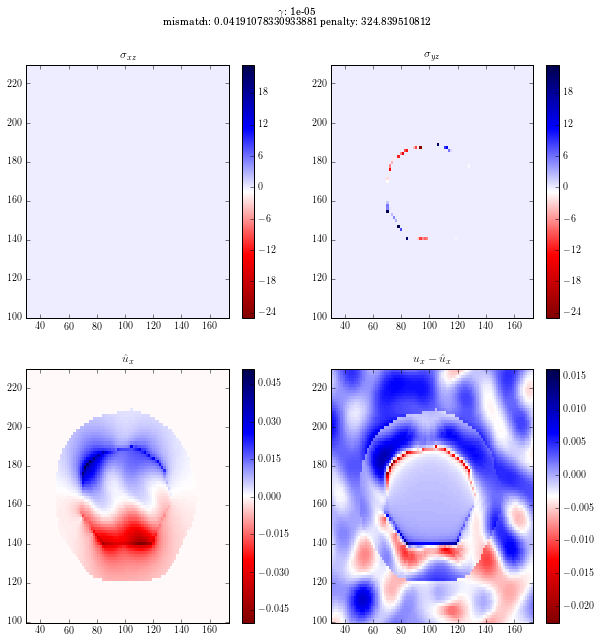

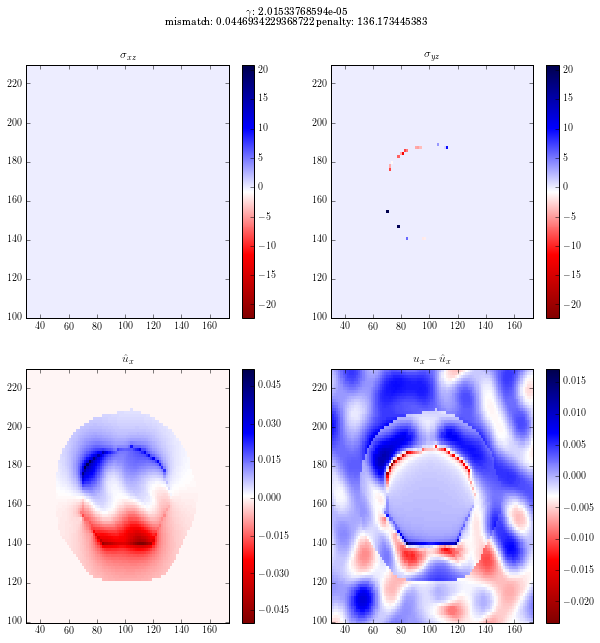

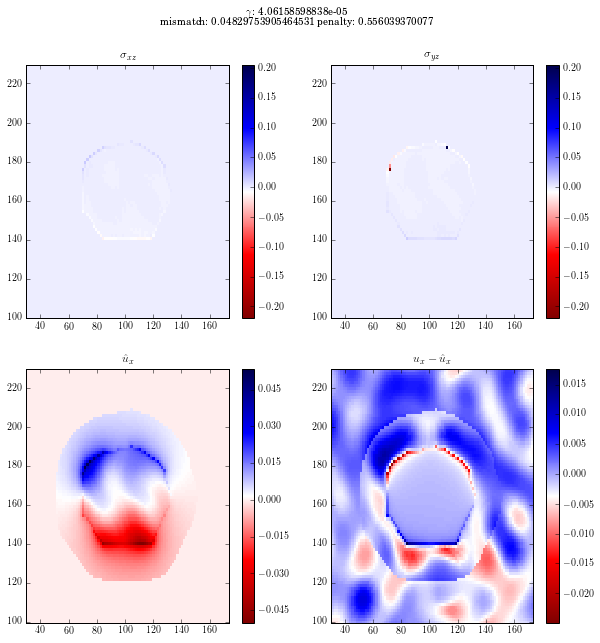

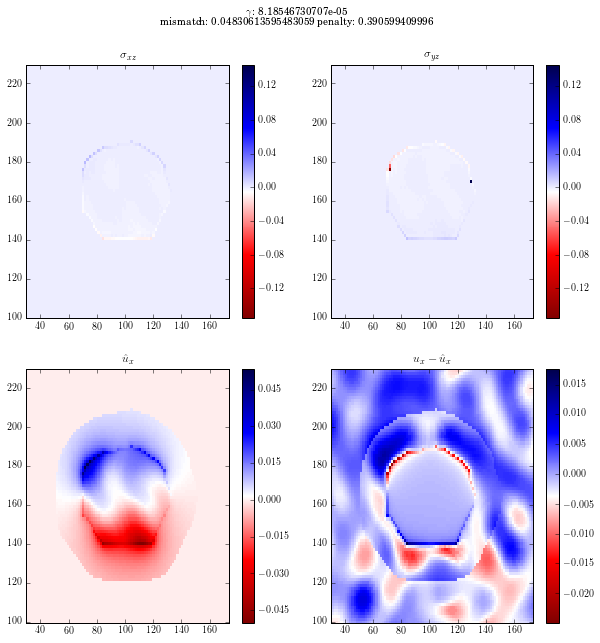

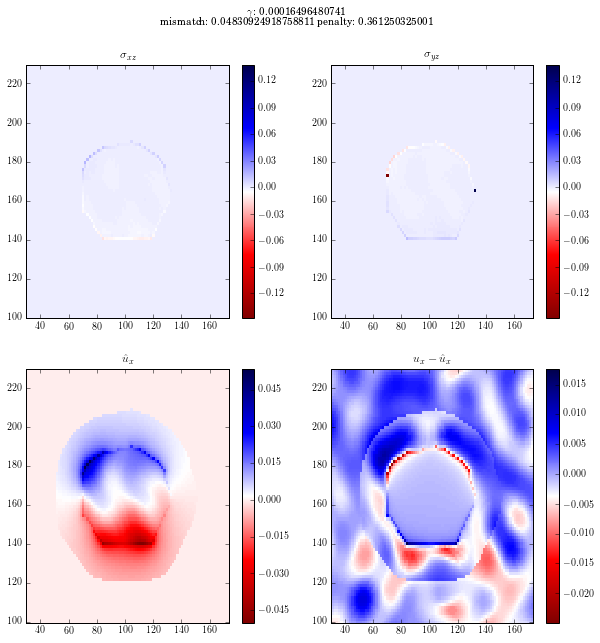

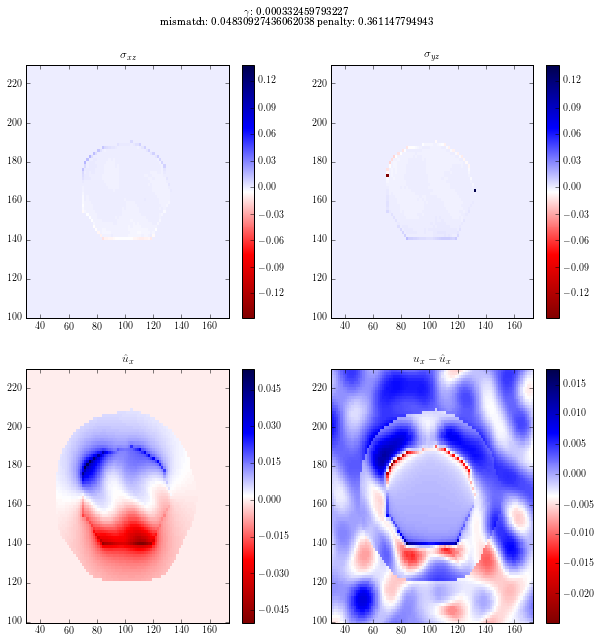

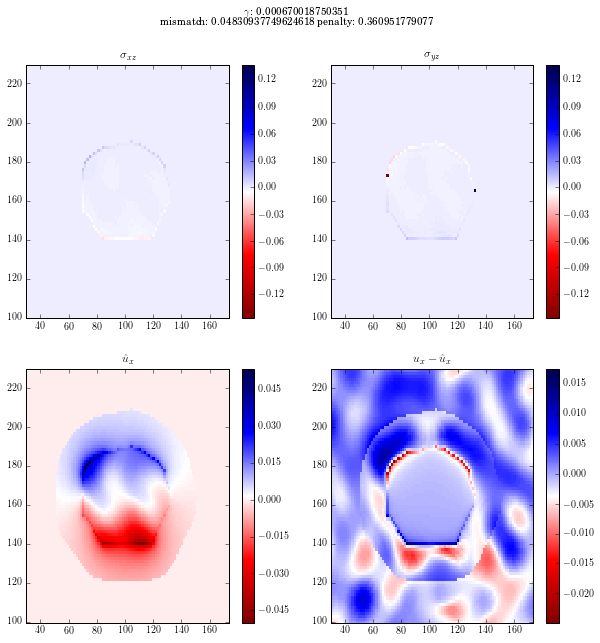

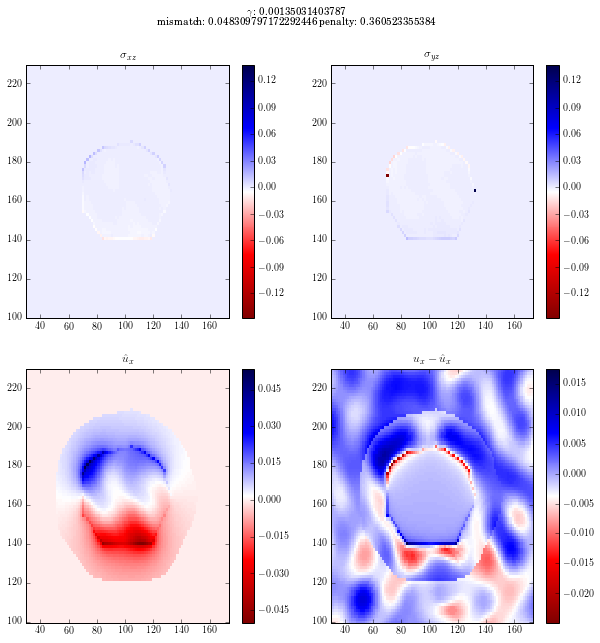

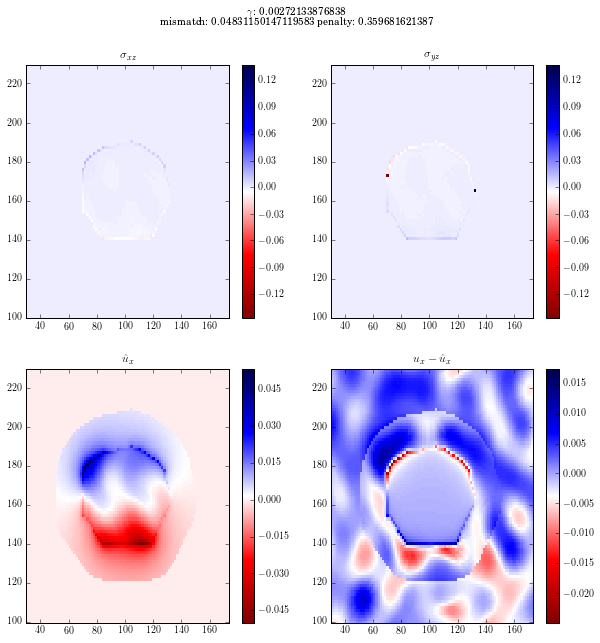

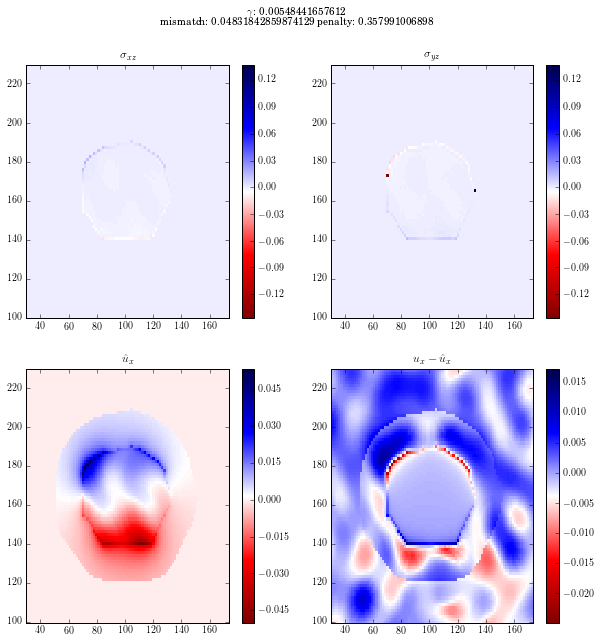

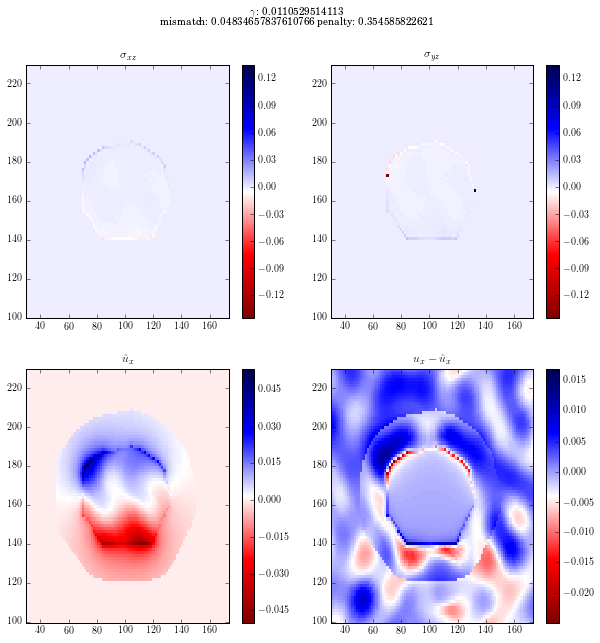

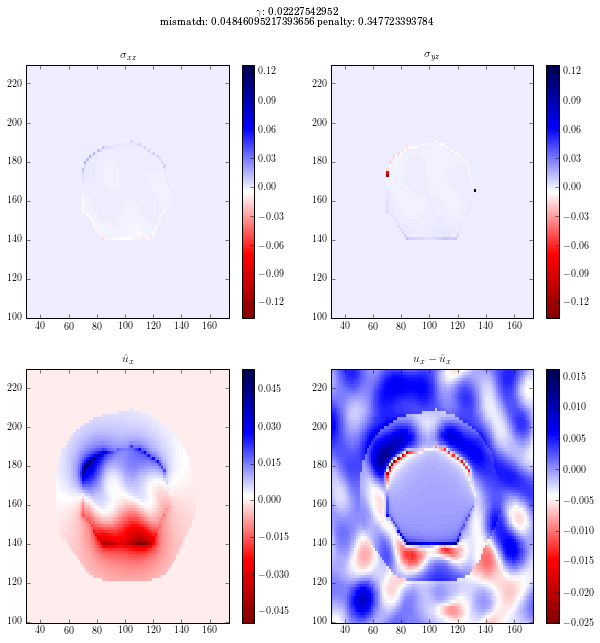

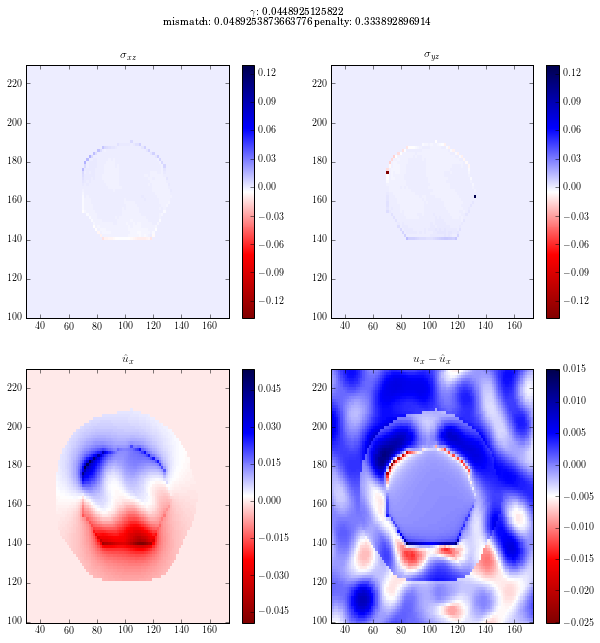

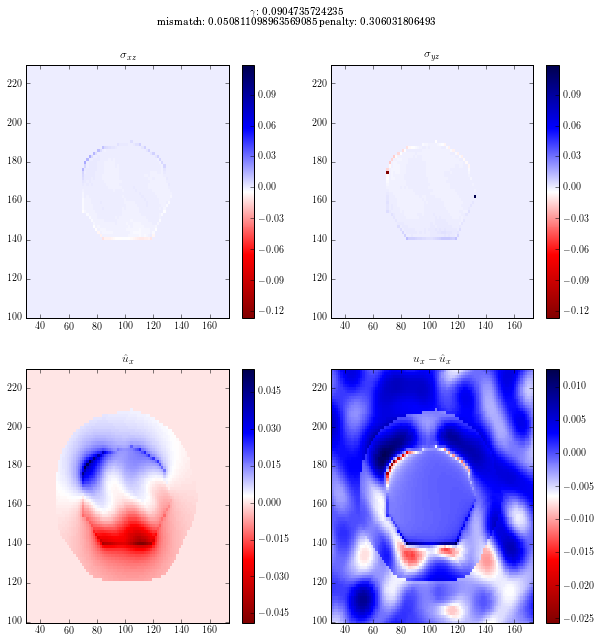

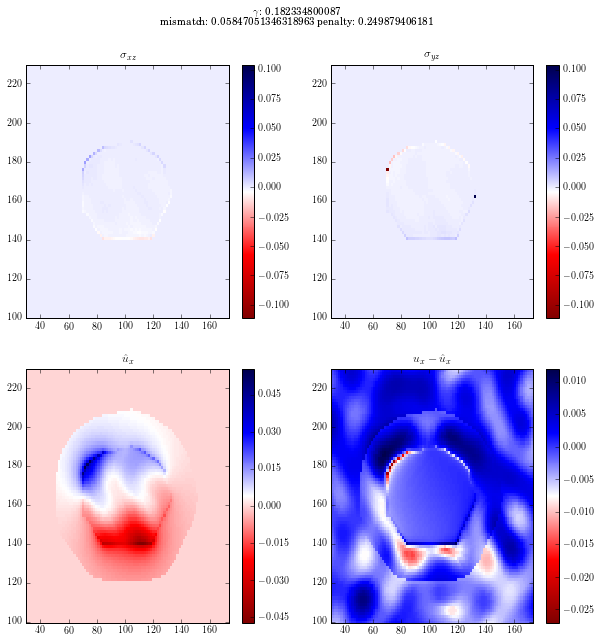

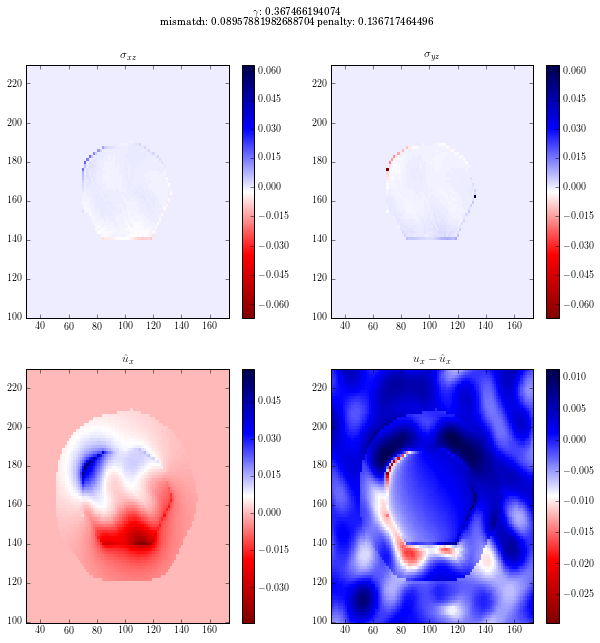

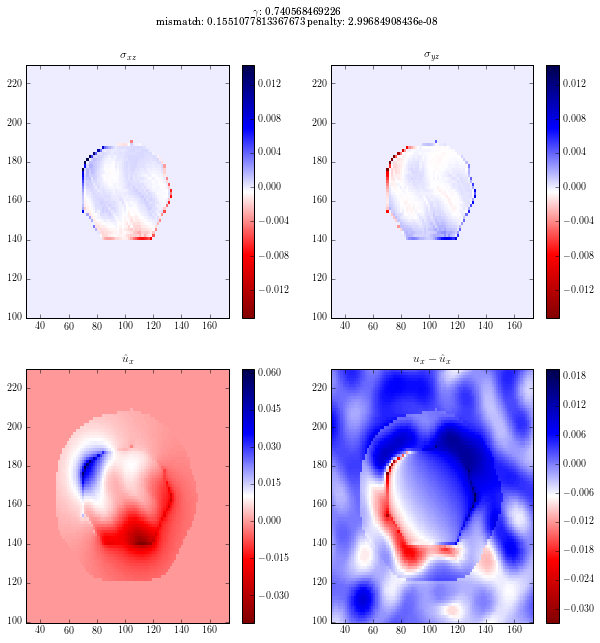

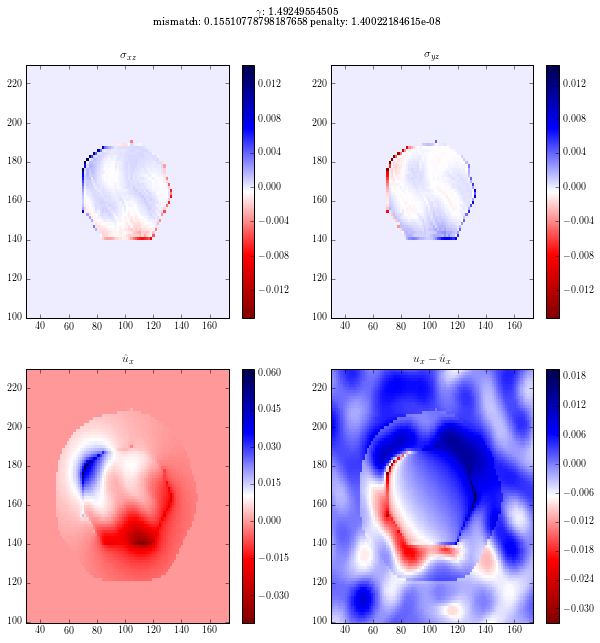

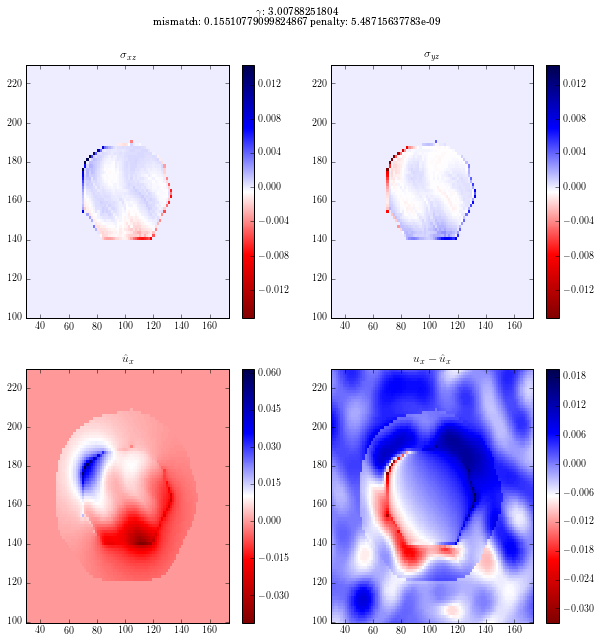

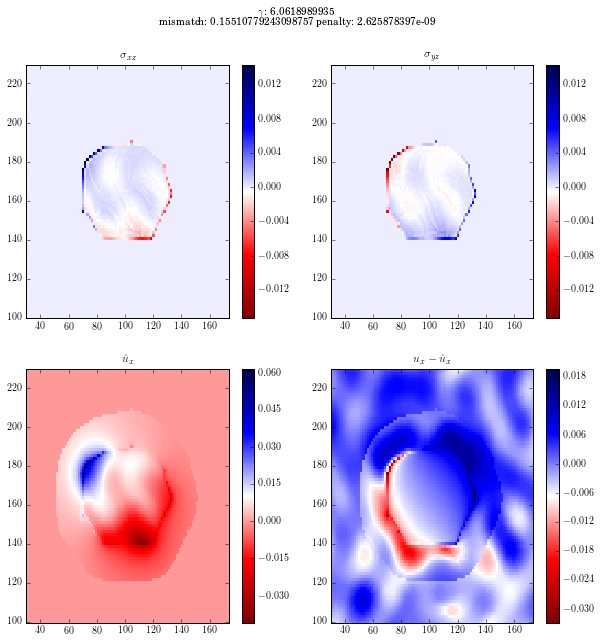

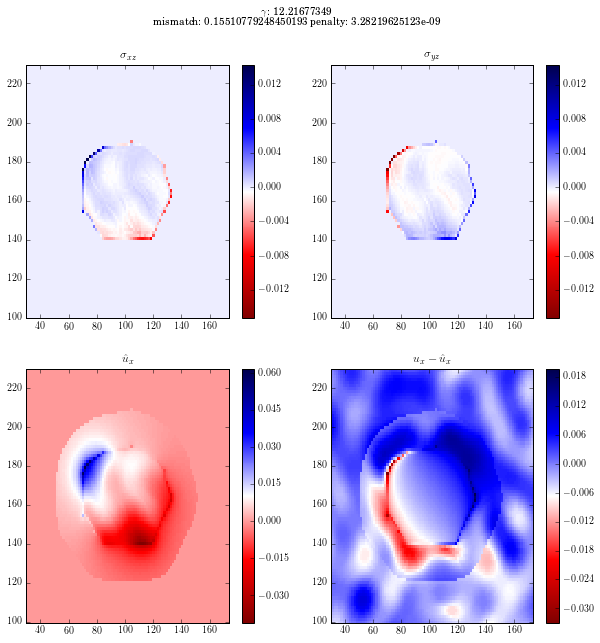

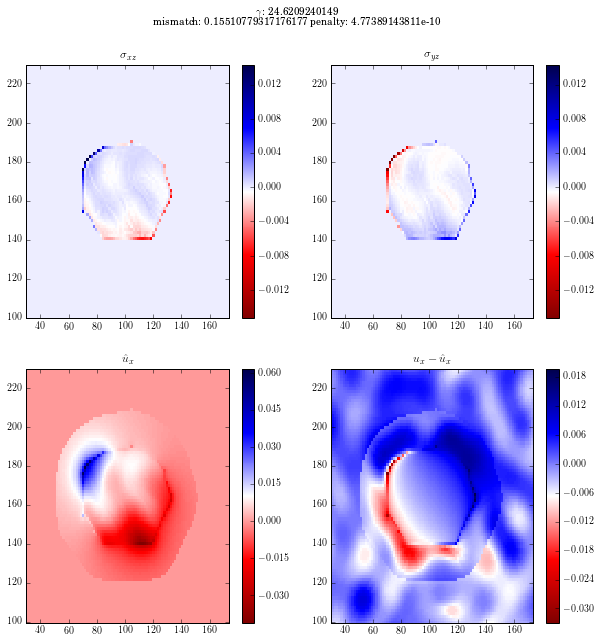

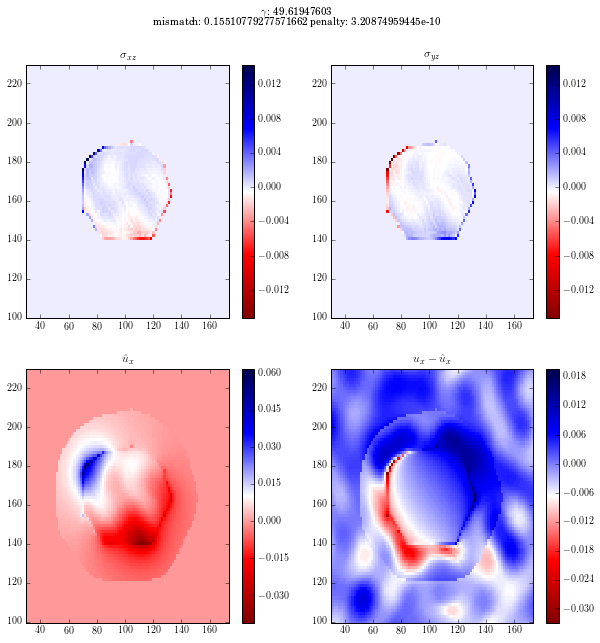

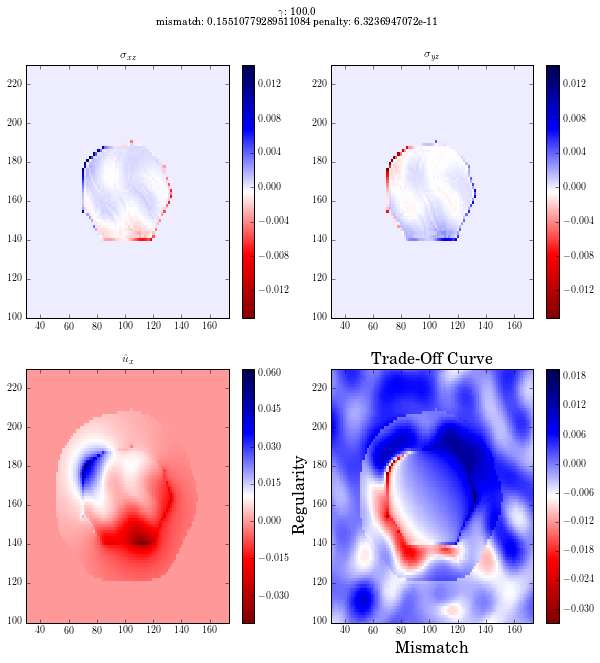

In [4]:
for j,val in enumerate(gamma_vals):
    gamma.value = val
    try:
        prob.solve(verbose= False, max_iters = 50,
                   warm_start=True, solver = cvxpy.ECOS,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6)

    except cvxpy.SolverError:
        continue

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    force = np.zeros_like(coords)
    force[condition_inside,0] = sigma_xz.value.reshape((n_in,))
    force[condition_inside,1] = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_x[condition_inside] = predicted_in.value
    u_x[condition_outside] = predicted_out.value
    #u_x_values.append(u_x)

    maxmagnitude = np.max(np.abs(force))

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.figure(figsize=(10, 10))

    x_min = min(coords[boundary == 1, 0])
    x_max = max(coords[boundary == 1, 0])
    y_min = min(coords[boundary == 1, 1])
    y_max = max(coords[boundary == 1, 1])

    plt.suptitle("$\gamma$: "+ str(val) + "\n" +
                 "mismatch: " + str(error.value) + " penalty: " + str(regularity_penalty.value))

    plt.subplot(221)
    plt.xlim((x_min - 40, x_max + 40))
    plt.ylim((y_min - 40, y_max + 40))
    plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,0].reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                   cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.8)
    plt.title("$\sigma_{xz}$")
    plt.colorbar()

    plt.subplot(222)
    plt.xlim((x_min - 40, x_max + 40))
    plt.ylim((y_min - 40, y_max + 40))
    plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,1].reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                   cmap='seismic_r',vmax = maxmagnitude*.75, vmin=-maxmagnitude*.8)
    plt.title("$\sigma_{yz}$")
    plt.colorbar()

    plt.subplot(223)
    plt.xlim((x_min - 40, x_max + 40))
    plt.ylim((y_min - 40, y_max + 40))
    plt.pcolormesh(x_obs_positions,y_obs_positions,u_x.reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                   cmap='seismic_r')
    plt.title("$\hat{u}_x$")
    plt.colorbar()

    plt.subplot(224)
    plt.xlim((x_min - 40, x_max + 40))
    plt.ylim((y_min - 40, y_max + 40))
    plt.pcolormesh(x_obs_positions,y_obs_positions,(deflection - u_x).reshape((len(x_obs_positions),len(y_obs_positions))).transpose(),
                   cmap='seismic_r')
    plt.title("$u_x-\hat{u}_x$")
    plt.colorbar()
    #plt.show()

plt.plot( sq_penalty, l1_penalty)
plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)


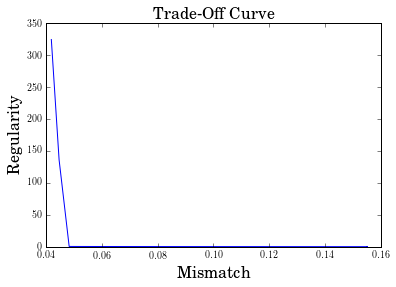

In [5]:
plt.plot( sq_penalty, l1_penalty)
plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)